In [1]:
import numpy as np
import cvxpy as cp
import torch

In [2]:
from scipy.linalg import eigh
from scipy.stats import chi2

In [3]:
from matplotlib import pyplot as plt

In [4]:
import warnings

### Synthetic Data from Kallus 2018

In [5]:
beta0 = 2.5
beta0_t = -2
beta_x = np.asarray([0, .5, -0.5, 0, 0])
beta_x_t = np.asarray([-1.5, 1, -1.5, 1., 0.5])
beta_xi = 1
beta_xi_t = -2
beta_e_x = np.asarray([0, .75, -.5, 0, -1])
mu_x = np.asarray([-1, .5, -1, 0, -1]);

def generate_data(n):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    U = (Y[0, :] > Y[1, :]).astype(int)
    z = X @ beta_e_x
    e_x = np.exp(z) / (1 + np.exp(z))
    e_xu = (6 * e_x) / (4 + 5 * U + e_x * (2 - 5 * U))
    T = (np.random.rand(n) < e_xu).astype(int)
    Y = Y[T, range(n)]
    return Y, T, X, U, e_x, e_xu

def evaluate_policy(policy, n=1000):
    xi = (np.random.rand(n) > 0.5).astype(int)
    X = mu_x[None, :] + np.random.randn(n * 5).reshape(n, 5)
    eps = [np.random.randn(n) for t in (0, 1)]
    Y = np.array([
        X @ (beta_x + beta_x_t * t) + (beta_xi + beta_xi_t * t) * xi + (beta0 + beta0_t * t) + eps[t]
        for t in (0, 1)
    ])
    e_x = policy(X)
    Y = torch.as_tensor(Y) if isinstance(e_x, torch.Tensor) else Y
    Y = Y[0, :] * (1 - e_x) + Y[1, :] * e_x
    return Y.mean()

In [8]:
np.random.seed(0)
n = 1000
Y, T, X, U, e_x, e_xu = generate_data(n)
p_t = e_x * T + (1 - e_x) * (1 - T)  # p_obs(T|X), e_x:=p(T=1|X)

In [9]:
def toy_policy(X):
    z = torch.as_tensor(X) @ torch.as_tensor(beta_e_x)
    e_x = torch.exp(z) / (1 + torch.exp(z))
    return e_x

# def zero_policy(X):
#    return np.zeros(X.shape[0], dtype=int)

### Estimate Propensity Score (Conditional Density Estimation)

#### Discrete Case

In [10]:
# Logistic regression is already quite good
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV().fit(X, T)
e_xx = model.predict_proba(X)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.03249897402679495

In [11]:
# But Kernel Logistic Regression is slightly better
import optuna
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def objective(trial):
    gamma = trial.suggest_float('gamma', 1e-2, 1e+2, log=True)
    lambd = trial.suggest_float('lambd', 1e-3, 1e+3, log=True)
    model = Pipeline([
        ('kpca', KernelPCA(n_components=100, kernel='rbf', gamma=gamma)),
        ('LogReg', LogisticRegression(C=1/lambd)),
    ])   
    cv_scores = cross_val_score(model, X, y=T, cv=4)
    return cv_scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(func=objective, n_trials=100)

In [332]:
study.best_params  # {'gamma': 0.010034979398825772, 'lambd': 0.21459944940837156}

{'gamma': 0.010034979398825772, 'lambd': 0.21459944940837156}

In [12]:
Z = KernelPCA(n_components=200, kernel='rbf', gamma=0.01).fit_transform(X)
model = LogisticRegression(C=5).fit(Z, T)
e_xx = model.predict_proba(Z)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.029285603729178284

In [13]:
np.mean(1 / e_x * T), np.mean(1 / (1 - e_x) * (1 - T)), # both should be 1

(1.0093131863700182, 0.9983494590525384)

In [14]:
np.mean(1 / e_xx * T), np.mean(1 / (1 - e_xx) * (1 - T)), # both should be 1

(0.9907217307572401, 0.958087223401684)

### Ground Truth

In [15]:
evaluate_policy(toy_policy, n=1000000)

tensor(3.8739, dtype=torch.float64)

### IPW estimator

In [16]:
def IPW(r, p_t, return_w=False):
    if isinstance(r, torch.Tensor):
        est = torch.mean(r / torch.as_tensor(p_t))
    else:
        est = np.mean(r / p_t)
    return (est, w) if return_w else est


In [19]:
policy_prob = toy_policy(X) * T + (1 - toy_policy(X)) * (1 - T)
est_ipw = IPW(torch.as_tensor(Y) * policy_prob, p_t)

In [20]:
est_ipw

tensor(3.8597, dtype=torch.float64)

### Implement Confounding Robust Hajek Estimator    

In [21]:
def confoundingRobustHajek(r, T, a, b, return_w=False):
    r_np = r.data.numpy() if isinstance(r, torch.Tensor) else r
    w = np.zeros_like(a)
    for t in set(T):
        r_t = r_np[T == t]
        a_t = a[T == t]
        b_t = b[T == t]
        with warnings.catch_warnings():  # to avoid user warning about multiplication operator with `*` and `@`
            warnings.simplefilter("ignore")
            w[T == t] = hajekLP(r_t, a_t, b_t, r.shape[0])
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est

def hajekLP(r, a, b, n):
    m = r.shape[0]
    w = cp.Variable(m)
    phi = cp.Variable()
    constraints = [
        np.zeros(m) <= w,
        0 <= phi,
        a * phi <= w,
        w <= b * phi,
        cp.sum(w) == n
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

In [22]:
def get_a_b(e_x, T, gamma):
    p_t = e_x * T + (1 - e_x) * (1 - T)  # p_obs(t|x)
    a = 1 + 1 / gamma * (1 / p_t - 1)
    b = 1 + gamma * (1 / p_t - 1)
    return a, b

In [23]:
a, b = get_a_b(e_xx, T, 1.5)
p_t = e_xx * T + (1 - e_xx) * (1 - T)

In [56]:
#a, b = get_a_b(e_x, T, 1.5)
#p_t = e_x * T + (1 - e_x) * (1 - T)

In [80]:
np.exp(np.max(np.abs(np.log(e_xx) - np.log(e_xu))))

2.6762249758638124

In [81]:
np.exp(np.max(np.abs(np.log(e_x) - np.log(e_xu))))

1.4395694088261581

In [57]:
est, w = confoundingRobustHajek(torch.as_tensor(Y) * policy_prob, T, a, b, return_w=True)

In [58]:
est

tensor(3.5273, dtype=torch.float64)

In [59]:
differentiable_r = torch.tensor(np.random.randn(T.shape[0]), requires_grad=True)
est, w = confoundingRobustHajek(differentiable_r, T, a, b, return_w=True)

In [60]:
est.backward()

In [61]:
torch.allclose(differentiable_r.grad, torch.as_tensor(w / n))

True

### Implement Confounding Robust Kernel Estimator

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF

In [63]:
def confoundingRobustKernel(r, T, X, a, b, p_t, alpha=0.01, return_w=False, rank_constraints=100, use_hajek_constraints=True):
    r_np = r.data.numpy() if isinstance(r, torch.Tensor) else r
    rank_constraints = min(rank_constraints, n)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if use_hajek_constraints:
            w = binaryKernelLP(r_np, T, X, a, b, p_t, alpha, rank_constraints)
        else:
            w = KernelLP(r_np, T, X, a, b, p_t, alpha, rank_constraints)
    if isinstance(r, torch.Tensor):
        est = torch.mean(torch.as_tensor(w) * r)
    else:
        est = np.mean(w * r_np)
    return (est, w) if return_w else est


def binaryKernelLP(r, T, X, a, b, p_t, alpha, rank_constraints):
    n = r.shape[0]
    assert rank_constraints <= n
    TX = np.concatenate([T[:, None], X], axis=1)
    _, w = confoundingRobustHajek(r, T, a, b, return_w=True)
    e = w * p_t - 1
    kernel_ = WhiteKernel() + ConstantKernel() * RBF()
    model = GaussianProcessRegressor(kernel=kernel_).fit(TX[:1000], e[:1000])

    lambd = model.kernel_.k1.noise_level
    kernel = model.kernel_.k2
    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[n-rank_constraints, n-1])
    
    w = cp.Variable(n)
    phi0 = cp.Variable()
    phi1 = cp.Variable()
    z = cp.Variable(rank_constraints)  # low-rank expression of error

    p_t_scaled = np.zeros_like(p_t)
    p_t_scaled[T == 0] = p_t[T == 0] * np.mean((1 - T) / p_t)
    p_t_scaled[T == 1] = p_t[T == 1] * np.mean(T / p_t)

    M = np.diag(S / (S + lambd)) @ V.T @ np.diag(p_t_scaled)
    u = np.diag(S / (S + lambd)) @ V.T @ np.ones(n)

    Cov_z = S - S ** 2 / (S + lambd)
    chi2_bound = chi2(df=rank_constraints).ppf(1 - alpha)

    constraints = [
        np.zeros(n) <= w,
        0 <= phi0,
        0 <= phi1,
        a * (1 - T) * phi0 + a * T * phi1 <= w,
        w <= b * (1 - T) * phi0 + b * T * phi1,
        cp.sum(w * (1 - T)) == n,
        cp.sum(w * T) == n,
        z == M @ w - u,
        cp.sum(z ** 2 / Cov_z) <= chi2_bound,
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value


def KernelLP(r, T, X, a, b, p_t, alpha, rank_constraints):
    n = r.shape[0]
    assert rank_constraints <= n
    w = cp.Variable(n)
    z = cp.Variable(rank_constraints)

    M, u, Cov_z = getGPQC(r, T, X, a, b, p_t, rank_constraints)
    chi2_bound = chi2(df=rank_constraints).ppf(1 - alpha)

    constraints = [
        np.zeros(n) <= w,
        a <= w,
        w <= b,
        z == M @ w - u,
        cp.sum(z ** 2 / Cov_z) <= chi2_bound,
    ]
    objective = cp.Minimize(cp.sum(r * w))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value

def getGPQC(r, T, X, a, b, p_t, rank_constraints, kernel=None):
    TX = np.concatenate([T[:, None], X], axis=1)
    _, w = confoundingRobustHajek(r, T, a, b, return_w=True)
    e = w * p_t - 1
    kernel_ = WhiteKernel() + ConstantKernel() * RBF()
    model = GaussianProcessRegressor(kernel=kernel_).fit(TX[:1000], e[:1000])

    lambd = model.kernel_.k1.noise_level
    kernel = model.kernel_.k2
    
    K = kernel(TX, TX)
    S, V = eigh(K, subset_by_index=[n - rank_constraints, n-1])
    M = np.diag(S / (S + lambd)) @ V.T @ np.diag(p_t)
    u = np.diag(S / (S + lambd)) @ V.T @ np.ones(n)
    Cov_z = S - S ** 2 / (S + lambd)

    return M, u, Cov_z

    

In [64]:
est, w = confoundingRobustKernel(torch.as_tensor(Y) * policy_prob, T, X, a, b, p_t, return_w=True)

In [65]:
est

tensor(3.6745, dtype=torch.float64)

In [66]:
est, w = confoundingRobustKernel(torch.as_tensor(Y) * policy_prob, T, X, a, b, p_t, return_w=True, use_hajek_constraints=False)

In [67]:
est  # without sum-up-to-one constraints

tensor(3.6975, dtype=torch.float64)

### Compare Policy Learning Performance

In [68]:
import tqdm

In [69]:
def base_policy(X):
    return 0.5 * torch.ones(X.shape[0], dtype=float)

def LR_policy(X, beta):
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=1)
    return torch.sigmoid(torch.tensor(X) @ beta)

In [70]:
class nnPolicy(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(5, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.Sigmoid(),
        )
        self.nn[-2].weight.data[:] = 0.
        self.nn[-2].bias.data[:] = 0.

    def forward(self, X):
        X = torch.as_tensor(X, dtype=torch.float32)
        return self.nn(X)[:, 0]

In [71]:
evaluate_policy(base_policy, n=100000)

tensor(3.7506, dtype=torch.float64)

In [72]:
nn_policy = nnPolicy()
evaluate_policy(nn_policy, n=100000)

tensor(3.7538, dtype=torch.float64, grad_fn=<MeanBackward0>)

#### Best Policy

In [73]:
train_steps = 101
beta_best = torch.zeros(6, requires_grad=True, dtype=float)
best_policy = lambda X: LR_policy(X, beta_best)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_best])
# best_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=1e-2, params=best_policy.parameters(), weight_decay=0.00)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    value = evaluate_policy(best_policy, n=100000)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

Value: 4.764907518636162: 100%|█████████████████████| 101/101 [00:07<00:00, 13.17it/s]


#### Just Run IPW optimization

In [74]:
train_steps = 101
beta_ipw = torch.zeros(6, requires_grad=True, dtype=float)
ipw_policy = lambda X: LR_policy(X, beta_ipw)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_ipw])
#ipw_policy = nnPolicy()
#optimizer = torch.optim.Adam(lr=1e-2, params=ipw_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    ipw_prob = ipw_policy(X) * torch.tensor(T) + (1 - ipw_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * ipw_prob
    value = IPW(r, p_t)
    (- value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {value}")

Value: 5.3468581321296895: 100%|███████████████████| 101/101 [00:00<00:00, 416.11it/s]


In [75]:
evaluate_policy(ipw_policy, n=100000)

tensor(4.4179, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [76]:
est = confoundingRobustKernel(r, T, X, a, b, p_t)
est

tensor(4.7409, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [77]:
est = confoundingRobustHajek(r, T, a, b)
est

tensor(4.5096, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [50]:
evaluate_policy(ipw_policy, n=100000)

tensor(4.4128, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [51]:
est = confoundingRobustKernel(r, T, X, a, b, p_t)
est

tensor(4.5570, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [52]:
est = confoundingRobustHajek(r, T, a, b)
est

tensor(4.3467, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [53]:
rank = [j ** 2 for j in range(1, 32)]
y = []
for i in tqdm.tqdm(rank):
    y.append(confoundingRobustKernel(r, T, X, a, b, p_t, rank_constraints=i))

100%|█████████████████████████████████████████████████| 31/31 [06:53<00:00, 13.35s/it]


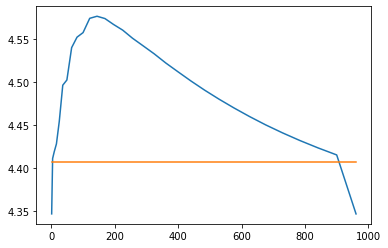

In [54]:
plt.plot(rank, [value.detach().numpy() for value in y])
plt.plot(rank, [evaluate_policy(ipw_policy, n=100000).detach().numpy()] * len(rank))

In [55]:
Y.std() / 1000 ** 0.5

0.09274408626053594

#### Compare Policy Improvement

In [80]:
# Hajek policy improvement
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X: LR_policy(X, beta_hajek)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_hajek])
# hajek_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=hajek_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    # base_prob =  0.5 * good_policy(X) * torch.tensor(T) + (1 - 0.5 * good_policy(X)) * torch.tensor(1 - T)
    base_prob =  base_policy(X) * torch.tensor(T) + (1 - base_policy(X)) * torch.tensor(1 - T)
    hajek_prob = hajek_policy(X) * torch.tensor(T) + (1 - hajek_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * (hajek_prob - base_prob)
    hajek_improvement, w = confoundingRobustHajek(r, T, a, b, return_w=True)
    (- hajek_improvement).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Improvement: {hajek_improvement}")

Improvement: 0.7050877439405984: 100%|██████████████| 101/101 [00:02<00:00, 42.11it/s]


In [81]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.6097, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [82]:
# Kernel policy improvement
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    base_prob =  base_policy(X) * torch.tensor(T) + (1 - base_policy(X)) * torch.tensor(1 - T)
    kernel_prob = kernel_policy(X) * torch.tensor(T) + (1 - kernel_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * (kernel_prob - base_prob)
    kernel_improvement, w = confoundingRobustKernel(r, T, X, a, b, p_t, return_w=True)
    (- kernel_improvement).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Improvement: {kernel_improvement}")

Improvement: 0.8608917177689175: 100%|██████████████| 101/101 [10:49<00:00,  6.43s/it]


In [83]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.6801, dtype=torch.float64, grad_fn=<MeanBackward0>)

### Just run min-max optimzation

In [84]:
# Hajek policy min-max value
train_steps = 101
beta_hajek = torch.zeros(6, requires_grad=True, dtype=float)
hajek_policy = lambda X: LR_policy(X, beta_hajek)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_hajek])
# NN seems to overfit
# hajek_policy = nnPolicy()
# hajek_policy = ipw_policy  # degrades the ipw policy
# optimizer = torch.optim.Adam(lr=1e-2, params=hajek_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    hajek_prob = hajek_policy(X) * torch.tensor(T) + (1 - hajek_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * hajek_prob
    hajek_value, w = confoundingRobustHajek(r, T, a, b, return_w=True)
    (- hajek_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {hajek_value}")

Value: 4.443990165195142: 100%|█████████████████████| 101/101 [00:02<00:00, 42.71it/s]


In [85]:
evaluate_policy(hajek_policy, n=100000)

tensor(4.5801, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [86]:
est = confoundingRobustKernel(r, T, X, a, b, p_t)
est

tensor(4.5772, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [87]:
# Kernel policy min-max value
train_steps = 101
beta_kernel = torch.zeros(6, requires_grad=True, dtype=float)
kernel_policy = lambda X: LR_policy(X, beta_kernel)
optimizer = torch.optim.RMSprop(lr=1e-1, params=[beta_kernel])
# kernel_policy = nnPolicy()
# optimizer = torch.optim.Adam(lr=3e-2, params=kernel_policy.parameters(), weight_decay=0.01)
pbar = tqdm.tqdm(range(train_steps))
for i in pbar:
    kernel_prob = kernel_policy(X) * torch.tensor(T) + (1 - kernel_policy(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * kernel_prob
    kernel_value, w = confoundingRobustKernel(r, T, X, a, b, p_t, return_w=True)
    (- kernel_value).backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_description(f"Value: {kernel_value}")

Value: 4.651300650946105: 100%|█████████████████████| 101/101 [10:04<00:00,  5.99s/it]


In [88]:
evaluate_policy(kernel_policy, n=100000)

tensor(4.6655, dtype=torch.float64, grad_fn=<MeanBackward0>)

### Conclusions
- The difference in performance is sample-dependent
  - If the sample is well confounded, then kernel + hajek tends to be better than hajek
- IPW estimator is good enough in most cases, so we might not actually need confounding-robust methods
- Still, kernel + hajek method offers better lower-bound of the policy value, so it must have some use cases.

### Make a Table for Slide

In [146]:
pi1 = lambda x: 0.5
pi2 = toy_policy
pi3 = best_policy
pi4 = hajek_policy
pi5 = kernel_policy
pi6 = ipw_policy

In [147]:
table = {}
for i, pi in tqdm.tqdm(enumerate([pi1, pi2, pi3, pi4, pi5, pi6])):
    table[f"$\\pi_{i+1}$"] = row = {}
    row['$V_\\text{inf}$'] = float(evaluate_policy(pi, n=100000))
    prob = pi(X) * torch.tensor(T) + (1 - pi(X)) * torch.tensor(1 - T)
    r = torch.tensor(Y) * prob
    row['$\\hat V_\\text{inf}^\\Hajek$'] = float(confoundingRobustHajek(r, T, a, b))
    row['$\\hat V_\\text{inf}^\\kernel$'] = float(confoundingRobustKernel(r, T, X, a, b, p_t))
    row['$\\hat V_\\text{inf}^\\text{IPW}$'] = float(IPW(r, p_t))

6it [00:36,  6.15s/it]


In [151]:
table_copy = table.copy()
table.pop("$\\pi_6$")

{'$V_\\text{inf}$': 4.671451375254245,
 '$\\hat V_\\text{inf}^\\text{IPW}$': 4.856568494405989,
 '$\\hat V_\\text{inf}^\\Hajek$': 4.427088859626212,
 '$\\hat V_\\text{inf}^\\kernel$': 4.6642975558017366}

In [152]:
print("\\begin{tabular}{ | m{4em} || " + "m{3em} " * len(table) + "| }")
print("\\hline")
header = "{}\t" + "&{}\t" * len(table) + "\\\\"
print(header.format("", *table.keys()))
print("\\hline")

row_names = table["$\\pi_1$"].keys()
for row in row_names:
    s = "{}\t" + "&{:1.3f}\t" * len(table) + "\\\\"
    print(s.format(row, *[col[row] for col in table.values()]))
    print("\\hline")
print("\\end{tabular}")


\begin{tabular}{ | m{4em} || m{3em} m{3em} m{3em} m{3em} m{3em} | }
\hline
	&$\pi_1$	&$\pi_2$	&$\pi_3$	&$\pi_4$	&$\pi_5$	\\
\hline
$V_\text{inf}$	&3.757	&3.898	&4.736	&4.576	&4.670	\\
\hline
$\hat V_\text{inf}^\text{IPW}$	&3.583	&3.920	&4.738	&4.722	&4.827	\\
\hline
$\hat V_\text{inf}^\Hajek$	&3.546	&3.716	&4.302	&4.447	&4.417	\\
\hline
$\hat V_\text{inf}^\kernel$	&3.566	&3.855	&4.548	&4.560	&4.652	\\
\hline
\end{tabular}


### Estimate Propensity Score (Conditional Density Estimation)
- This requires consistent nominal propensity score (p_obs(t|x))
- For discrete t, just run kernel logistic regressionregret_kernel

#### Discrete Case

In [356]:
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score, make_scorer
# roc_auc_score = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)

model = LogisticRegressionCV().fit(X, T)
e_xx = model.predict_proba(X)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.03245225608333301

In [9]:
import optuna
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def objective(trial):
    gamma = trial.suggest_float('gamma', 1e-2, 1e+2, log=True)
    lambd = trial.suggest_float('lambd', 1e-3, 1e+3, log=True)
    model = Pipeline([
        ('kpca', KernelPCA(n_components=100, kernel='rbf', gamma=gamma)),
        ('LogReg', LogisticRegression(C=1/lambd)),
    ])   
    cv_scores = cross_val_score(model, X, y=T, cv=4)
    return cv_scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(func=objective, n_trials=100)

In [332]:
study.best_params

{'gamma': 0.010034979398825772, 'lambd': 0.21459944940837156}

In [10]:
Z = KernelPCA(n_components=200, kernel='rbf', gamma=0.01).fit_transform(X)
model = LogisticRegression(C=5).fit(Z, T)
e_xx = model.predict_proba(Z)[:, 1]

np.mean(np.abs(e_xx - e_x))

0.023502960435053497

In [11]:
np.mean(1 / e_x * T), np.mean(1 / (1 - e_x) * (1 - T)), # both should be 1

(0.9926845079200554, 0.9795193002344411)

In [12]:
np.mean(1 / e_xx * T), np.mean(1 / (1 - e_xx) * (1 - T)), # both should be 1

(0.9978398603769248, 0.9503035986662446)

#### Continuous Case (Maybe on the next notebook)

In [598]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

In [614]:
EPS = 1e-6

def benchmark_bandwidth(bw, T, X, cv=5):
    n = T.shape[0]
    indep_type='c' * X.shape[1]
    dep_type='u'
    split = (np.arange(n) % 5)
    cross_entropy = 0
    for i in range(cv):
        train = (split != i)
        test = (split == i)
        model = KDEMultivariateConditional(T[train, None], X[train, :], dep_type='c', indep_type='c' * X.shape[1], bw=bw)
        cross_entropy += np.mean(model.pdf(T[test, None], X[test, :]) + EPS) / cv
    return cross_entropy

In [615]:
best_scale = 0
best_score = - float('inf')
for scale in [0.1, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5]:
    bw = scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
    score = benchmark_bandwidth(bw, Y, X)
    if score > best_score:
        best_scale = scale
        best_score = score

/home/kei/Desktop/env_pillbox/lib/python3.8/site-packages/statsmodels/nonparametric/kernel_density.py:527: RuntimeWarning: invalid value encountered in double_scalars
  pdf_est.append(f_yx / f_x)


In [616]:
best_scale, best_score

(0.3, 0.19784318708431387)

In [637]:
bw0 = best_scale * np.concatenate([[Y.std()], X.std(axis=0)]) / Y.shape[0] ** (1 / 7)
model = KDEMultivariateConditional(Y[:, None], X, dep_type='c', indep_type='c' * X.shape[1], bw=bw0)

In [638]:
e_xx = model.pdf(Y[:, None], X)
e_xx

array([1.62958717, 1.62951695, 1.62941804, ..., 1.62956773, 1.62958717,
       1.62958716])

(array([3.000e+00, 5.000e+00, 7.000e+00, 9.000e+00, 2.100e+01, 2.500e+01,
        2.900e+01, 4.700e+01, 1.230e+02, 7.731e+03]),
 array([1.15235734, 1.20008033, 1.24780331, 1.29552629, 1.34324927,
        1.39097226, 1.43869524, 1.48641822, 1.5341412 , 1.58186419,
        1.62958717]),
 <BarContainer object of 10 artists>)

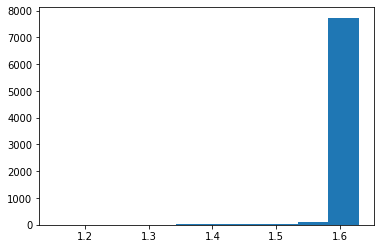

In [639]:
plt.hist(e_xx)

In [640]:
model.bw

array([0.24481187, 0.08247946, 0.08201479, 0.08216818, 0.08203077,
       0.08354723])

In [636]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.0036205488784271846,
 0.005530541824885594,
 0.008353342645354245,
 0.0092354679017507,
 0.008828923218367986,
 0.006834553073471655,
 0.0047634763845408505]

In [650]:
# Shouldn't we use loo estimate for propensity? (For reducing the sampling bias)

In [651]:
model_loocv = KDEMultivariateConditional(Y[:500, None], X[:500], dep_type='c', indep_type='c' * X.shape[1], bw='cv_ml')
model_loocv = KDEMultivariateConditional(Y[:, None], X, dep_type='c', indep_type='c' * X.shape[1], bw=model_loocv.bw)
model_loocv.pdf(T[:, None], X)

array([0.00156597, 0.11336096, 0.18019459, ..., 0.15350272, 0.27772491,
       0.00683612])

In [652]:
model_loocv.bw

array([1.16864112, 0.39784615, 0.47414212, 0.34012805, 0.49598966,
       1.03207938])

In [653]:
e_xx = model_loocv.pdf(Y[:, None], X)
e_xx

array([0.16803556, 0.19643081, 0.13837616, ..., 0.08974823, 0.28981744,
       0.16892645])

In [654]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.42097172629623864,
 0.5610275108978744,
 0.7806948645405306,
 0.8323803841286099,
 0.8266400377542329,
 0.6698018012108039,
 0.4903058358518989]

In [660]:
Y, T, X, U, e_x, e_xu = generate_data(2000)

In [661]:
# Maybe better to use gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF
from scipy.stats import norm

kernel = WhiteKernel() + ConstantKernel() * RBF()
model = GaussianProcessRegressor(kernel=kernel).fit(X, Y)
mu, sigma = model.predict(X, return_std=True)
e_xx = norm.pdf(Y, loc=mu, scale=sigma)

(array([ 76.,  55.,  81.,  93., 115., 140., 171., 221., 272., 776.]),
 array([2.06249815e-07, 2.74513965e-02, 5.49025868e-02, 8.23537771e-02,
        1.09804967e-01, 1.37256158e-01, 1.64707348e-01, 1.92158538e-01,
        2.19609729e-01, 2.47060919e-01, 2.74512109e-01]),
 <BarContainer object of 10 artists>)

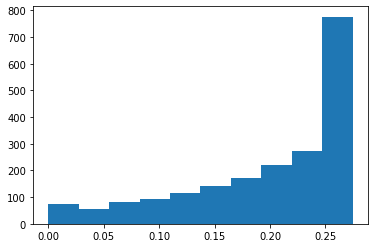

In [662]:
plt.hist(e_xx)

In [663]:
[np.mean(1. / e_xx * ((i <= Y) & (Y <= i + 1))) for i in range(7)]  # Should go to 1

[0.32881986213236836,
 0.7800613489446759,
 1.1082520007466337,
 2425.996762904727,
 2.3731976440293625,
 3.270582402658918,
 1.5545976263818995]